/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


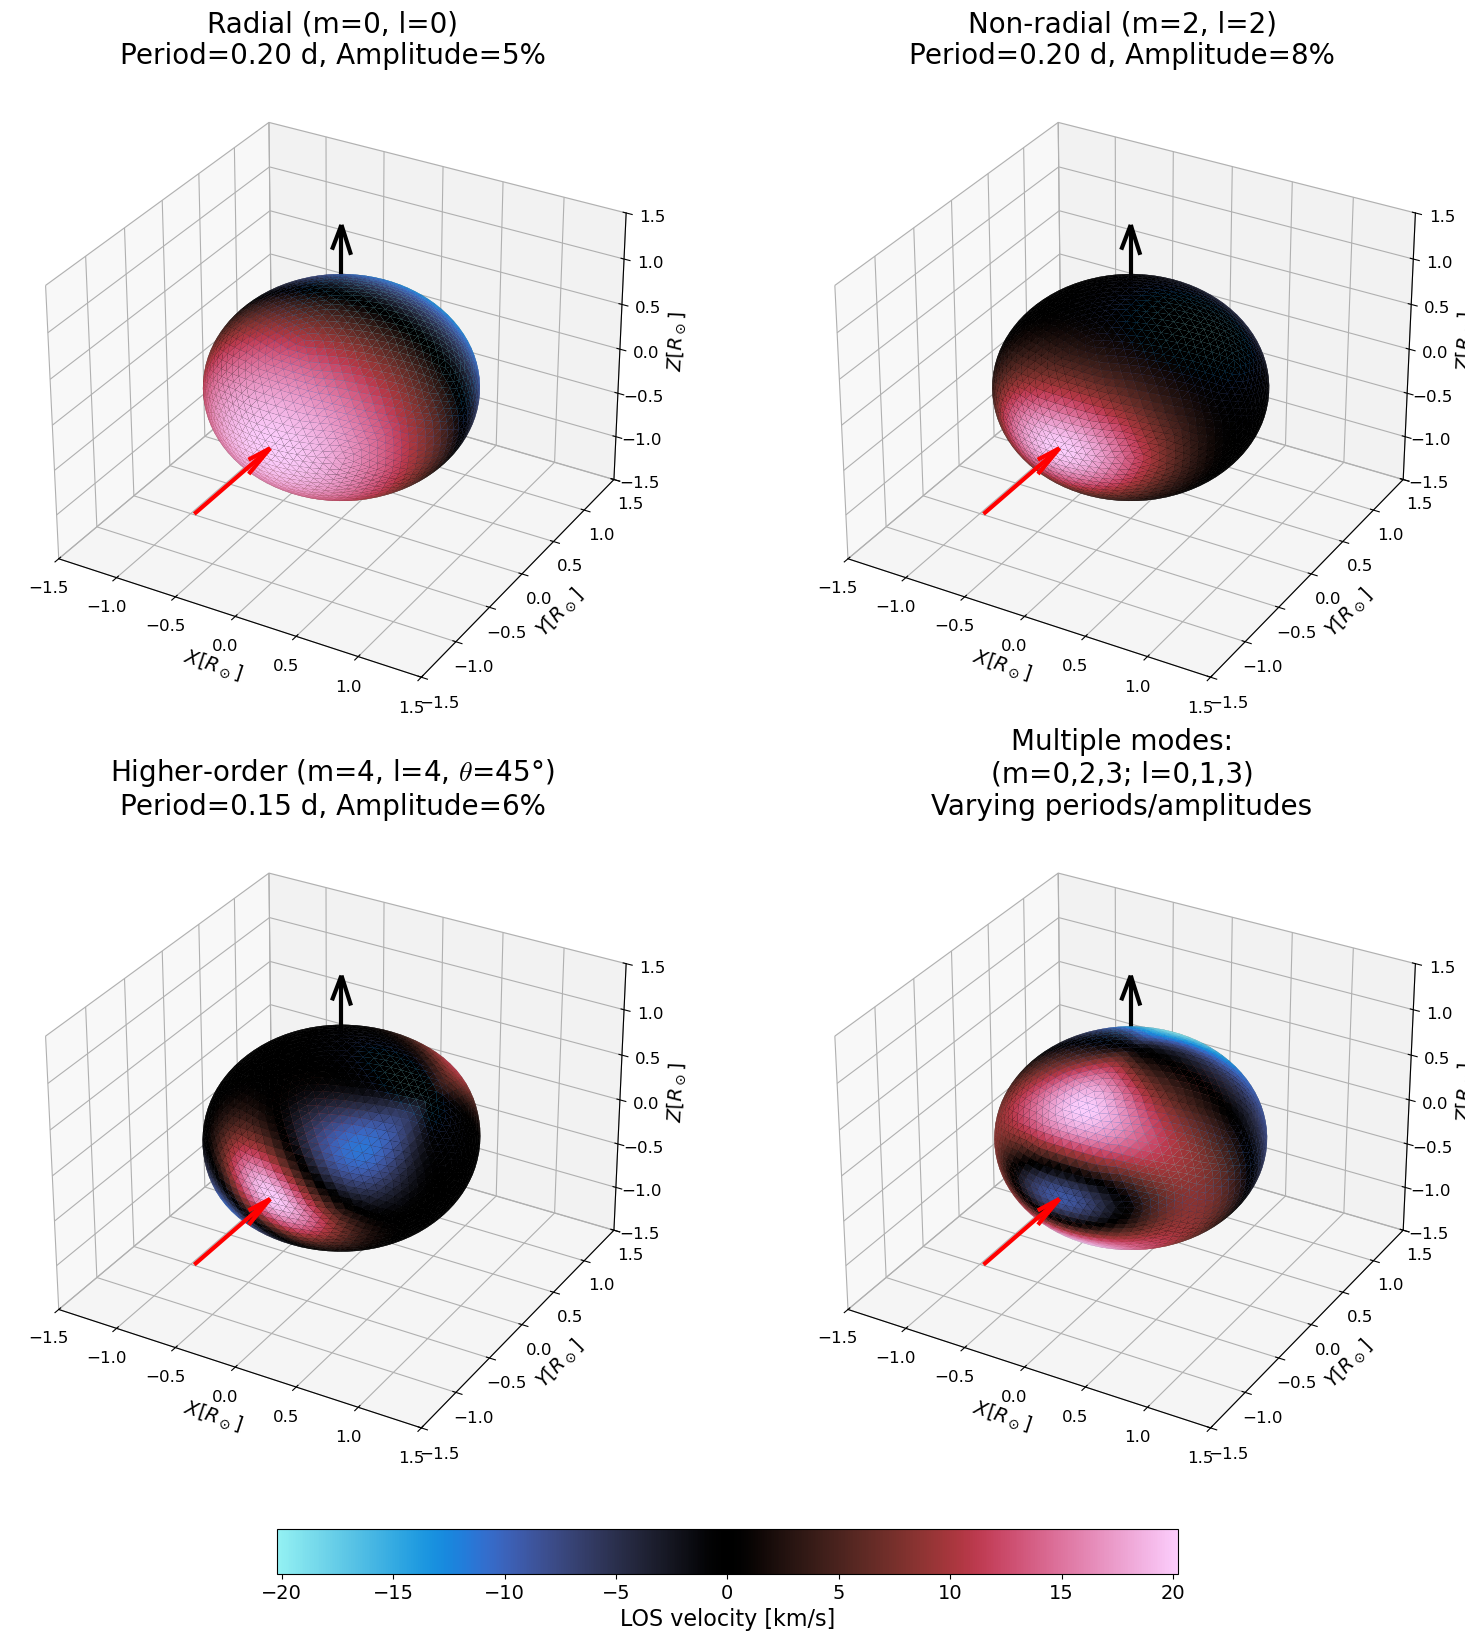

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, add_pulsations, evaluate_pulsations
from spice.plots import plot_3D
from transformer_payne import Blackbody

base_temp = 5700
bb = Blackbody()

# Create base model with 5700K temperature
m = IcosphereModel.construct(
    5000, 1., 1.,
    bb.to_parameters(dict(teff=base_temp)),
    bb.parameter_names
)

# Construct 4 pulsating models
# 1. Radial, 2. Nonradial, 3. Higher-order & tilted, 4. Multiple modes

m_pulsation1 = add_pulsation(
    m, m_order=jnp.array([0]), l_degree=jnp.array([0]),
    period=jnp.array([0.20]),
    fourier_series_parameters=jnp.array([[0.05, 0.0]])
)
# Use the same evaluation time for all panels for comparison
ev_time = 0.05
m_pulsation1 = evaluate_pulsations(m_pulsation1, ev_time)

m_pulsation2 = add_pulsations(
    m,
    m_orders=jnp.array([2]), l_degrees=jnp.array([2]),
    periods=jnp.array([0.20]),
    fourier_series_parameters=jnp.array([[0.08, 0.0]])
)
m_pulsation2 = evaluate_pulsations(m_pulsation2, ev_time)

m_pulsation3 = add_pulsations(
    m,
    m_orders=jnp.array([4]), l_degrees=jnp.array([4]),
    periods=jnp.array([0.15]),
    fourier_series_parameters=jnp.array([[0.06, 0.0]]),
    pulsation_axes=jnp.array([[0.0, 1.0, 0.0]]),
    pulsation_angles=jnp.array([45.])
)
m_pulsation3 = evaluate_pulsations(m_pulsation3, ev_time)

m_pulsation4 = add_pulsations(
    m,
    m_orders=jnp.array([0, 2, 3]), l_degrees=jnp.array([0, 1, 3]),
    periods=jnp.array([0.15, 0.10, 0.20]),
    fourier_series_parameters=jnp.array([
        [0.03, 0.0], [0.04, 0.0], [0.05, 0.0]
    ])
)
m_pulsation4 = evaluate_pulsations(m_pulsation4, ev_time)

# Gather min/max LOS velocities for color normalization
props = [
    np.asarray(m_pulsation1.los_velocities),
    np.asarray(m_pulsation2.los_velocities),
    np.asarray(m_pulsation3.los_velocities),
    np.asarray(m_pulsation4.los_velocities),
]
all_props = np.concatenate(props)
vmin = float(np.min(all_props))
vmax = float(np.max(all_props))
from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
# Use cmasher or fallback to perceptually uniform default
cmap = 'cmr.redshift'

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2, projection='3d')],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]

# Titles (explicit, not using f-strings, for stable mathtext rendering)
puls_titles = [
    "Radial (m=0, l=0)\n" + r"Period=0.20 d, Amplitude=5%",
    "Non-radial (m=2, l=2)\n" + r"Period=0.20 d, Amplitude=8%",
    "Higher-order (m=4, l=4, $\\theta$=45°)\n" + r"Period=0.15 d, Amplitude=6%",
    "Multiple modes:\n(m=0,2,3; l=0,1,3)\n" + r"Varying periods/amplitudes"
]

for ax, model, title in zip(
    [axes[0][0], axes[0][1], axes[1][0], axes[1][1]],
    [m_pulsation1, m_pulsation2, m_pulsation3, m_pulsation4],
    puls_titles
):
    fig_ax = plot_3D(
        model, property='los_velocities', axes=(fig, ax),
        cmap=cmap, property_label="LOS velocity [km/s]", update_colorbar=False
    )
    # Patch color normalization
    if hasattr(ax, 'collections') and ax.collections:
        collection = ax.collections[0]
        vals = np.asarray(model.los_velocities)
        collection.set_facecolor(plt.get_cmap(cmap)(norm(vals)))
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        ax.legend_.remove()
    ax.set_title(rf"{title}", fontsize=20, math_fontfamily="cm")

plt.tight_layout()
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=plt.get_cmap(cmap), norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax for row in axes for ax in row], fraction=0.03, pad=0.04,
    orientation='horizontal'
)
cbar.set_label("LOS velocity [km/s]", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [8]:
fig.savefig('pulsations_harmonic.png', dpi=300, bbox_inches='tight')